# 1) Description and Source of Data

http://db.idrblab.net/ttd/sites/default/files/ttd_database/P2-01-TTD_uniprot_all.txt 


Therapeutic Target Database (TTD) is a database that provides information about the known and explored therapeutic proteins and nucleic acid targets, the targeted disease, pathway information and the corresponding drugs directed at each of these targets. Examples of its annotations are:
- patented
- discontinued
- on the market
- clinical development/trials
- preclinical research

We are using the information of all the above mentioned buckets to retrieve our ground truth label

### 1.1) Mount google drive to colab

In [ ]:
# mount google drive to colab
from google.colab import drive
import os
n = 140
drive.mount('/content/drive')
print("#" * n)

# change working directory
print("### colabs default working directory")

print("###\n### path: {}".format(os.getcwd()))
print("#" * n)
print("### setted working directory")

%cd drive/Shareddrives/MADS_Milestone1/

print("###\n### {}".format(os.getcwd()))
print("#" * n)



Mounted at /content/drive
############################################################################################################################################
### colabs default working directory
###
### path: /content
############################################################################################################################################
### setted working directory
/content/drive/Shareddrives/MADS_Milestone1
###
### /content/drive/Shareddrives/MADS_Milestone1
############################################################################################################################################


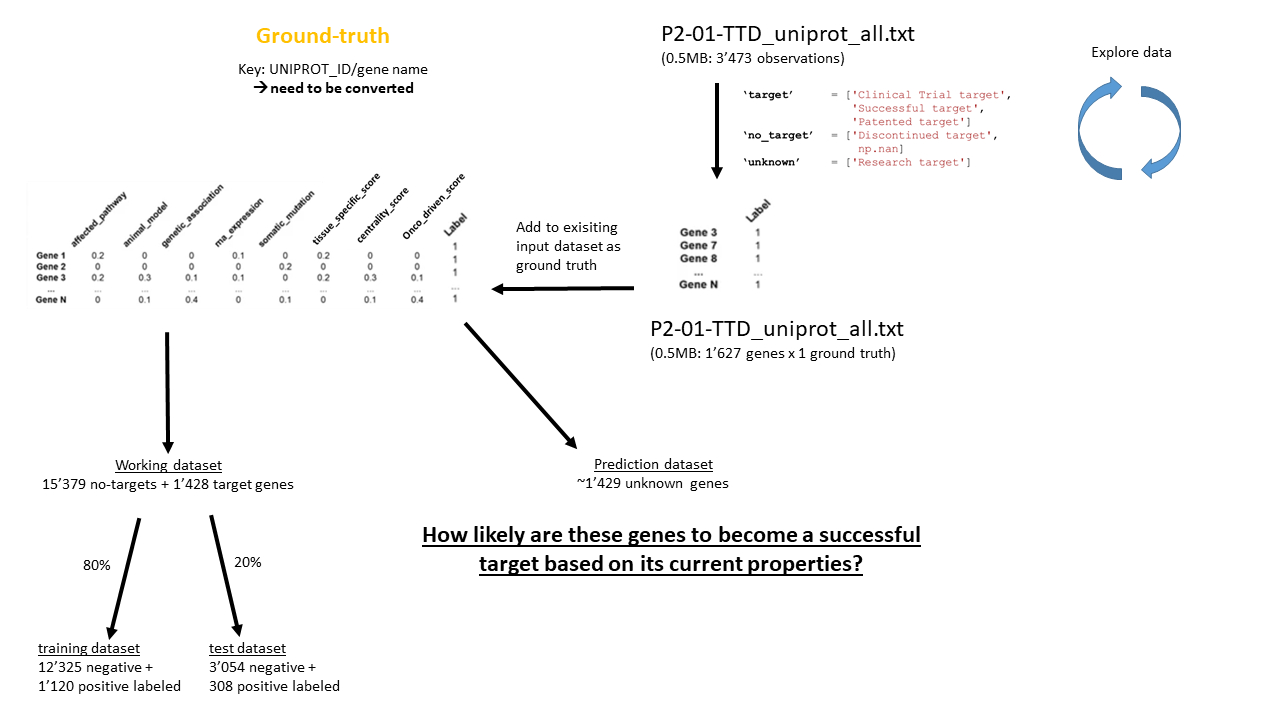

In [ ]:
from IPython.display import Image
Image('Visualizations/ground_truth.png', width=900, height=500)


### 1.2) Catch all files in directory

In [ ]:
import subprocess
import re

# define the ls command to find all results
ls = subprocess.Popen(["ls", "-p", "./Raw_Assets"],
                      stdout=subprocess.PIPE,
                     )

# define the grep command to exclude all folders
grep = subprocess.Popen(["grep", "-v", "/$"],
                        stdin=ls.stdout,
                        stdout=subprocess.PIPE,
                        )

# read from the end of the pipe (stdout)
endOfPipe = grep.stdout

json = {}
txt = {}
csv = {}
gmt = {}
all = []
path = "Raw_Assets/"
# output the files line by line
for line in endOfPipe:  
    
    w = re.sub( "\\\\n'$", "", str(line))
    w = re.sub("^b'", "", w)
    front = re.sub("\d+.", "", w)
    name = re.sub("\..*", "", front)

    all.append(w)
    if ".json" in w:        
        json[name] = path + w
    elif ".txt" in w or ".tsv" in w:
        txt[name] = path + w
    elif ".csv" in w:
        csv[name] = path + w
    else:
        gmt[name] = path + w
    
    
    
#     if (w[0] == "C") | (w[0] == "D"):
#         colnames.append(w)

### 1.3) Download ground truth dataset to infer status of potential target

In [ ]:
import os

n = 80
if "PTTD_uniprot_all" not in txt.keys():
  # download STRING interactome of human protein
  print("#"* n)
  print("### Download human protein interactome file to working directory") 
  print("#"* n)
  print("### path: {}".format(os.getcwd()))
  print("#"* n)
  %cd Raw_Assets/
  
  !wget http://db.idrblab.net/ttd/sites/default/files/ttd_database/P2-01-TTD_uniprot_all.txt
  
  %cd ../
else: 
  print("#"* n)
  print("### file already exists in working directory")
  print("#"* n)
  print("### path: {}\n### sub-directory: {}".format(os.getcwd(), txt["PTTD_uniprot_all"]))
  
  print("###\n### --> no need to download it again!")
  print("#"* n)
  

################################################################################
### file already exists in working directory
################################################################################
### path: /content/drive/Shareddrives/MADS_Milestone1
### sub-directory: Raw_Assets/P2-01-TTD_uniprot_all.txt
###
### --> no need to download it again!
################################################################################


# 2) Fetch ground truth labels for each target

### 2.1) import libraires

In [ ]:
# importing libraries

import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None) # Setting max number of dataframe rows to show
pd.set_option('display.max_columns', None) # Setting max number of dataframe cols to show
import matplotlib.pyplot as plt


### 2.2) import dataset

In [ ]:
label = pd.read_table(txt['PTTD_uniprot_all'], skiprows=21, header=0)
label = label.unstack().T.reset_index(level=[0], drop=True).T
label.head()


,TARGETID,TARGNAME,TARGTYPE,UNIPROID
T00032,T00032,Osteopontin (SPP1),Research target,OSTP_HUMAN
T00033,T00033,Transforming growth factor alpha (TGFA),Clinical Trial target,TGFA_HUMAN
T00037,T00037,Fungal Sterol 24-C-methyltransferase (Fung erg6),Research target,ERG6_PNEC8
T00039,T00039,CTGF messenger RNA (CTGF mRNA),Clinical Trial target,CTGF_HUMAN
T00075,T00075,CDC42 binding protein kinase alpha (DMPK-like ...,Research target,MRCKA_HUMAN


#### 2.2.1) map targets to gene symbols

This dataset contains only Uniproid names (note these are not the ids which could be used easily to convert) and targetnames. I try to derive the gene symbol via the targetname first.

In [ ]:
label["SYMBOL"] = [ str.upper(i) for i in label.TARGNAME.str.replace(".*\(", "").str.replace("\)", "").str.replace(" .*", "")] #list(map(str.upper, label.TARGNAME.str.replace(".*\(", "").str.replace("\)", "").str.replace(" .*", "")))

label.head()

,TARGETID,TARGNAME,TARGTYPE,UNIPROID,SYMBOL
T00032,T00032,Osteopontin (SPP1),Research target,OSTP_HUMAN,SPP1
T00033,T00033,Transforming growth factor alpha (TGFA),Clinical Trial target,TGFA_HUMAN,TGFA
T00037,T00037,Fungal Sterol 24-C-methyltransferase (Fung erg6),Research target,ERG6_PNEC8,FUNG
T00039,T00039,CTGF messenger RNA (CTGF mRNA),Clinical Trial target,CTGF_HUMAN,CTGF
T00075,T00075,CDC42 binding protein kinase alpha (DMPK-like ...,Research target,MRCKA_HUMAN,DMPK-LIKE


next I test how good that approach is by matching the symbols to the mygene API.

In [ ]:
!pip install mygene
import mygene

mg = mygene.MyGeneInfo()

q = mg.querymany(label.SYMBOL, scopes="symbol", fields="alias,symbol,pid", 
                   species="human", returnall=True)


querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-3473...done.
Finished.
123 input query terms found dup hits:
	[('TGFA', 2), ('MDM2', 2), ('PRKCE', 2), ('WWP2', 2), ('GHR', 2), ('TF', 2), ('CCR3', 2), ('DMD', 3)
1034 input query terms found no hit:
	['FUNG', 'CTGF', 'DMPK-LIKE', '5-LOX', 'NFKB', 'BACT', 'ABL', 'HIV', 'BACT', 'GLUT9', 'JNK3', 'COT',


In [ ]:
def catch_matched_symbols(query=q, alltrue=True):
  l = {}  
  # then try to query for the gene synonyms if available
  if alltrue:
    # loop through all gene synonym queries
    for L in query["out"]:
      key = [k for k in L.keys()]
      value = [v for v in L.values()]
      gene = L["query"]

      if "symbol" in key:
        b = value[key.index("symbol")]
        l[gene] = b

      # # check if the gene symbol of the query was assigned as exact synonym match
      # if "alias" in key:
      #   if gene in value[key.index("alias")]:
      #     # check if that gene synonym also contain a ensemblID
      #     b = value[key.index("symbol")]
      #     l[gene] = b
      # elif "symbol" in key:
      #   if gene in value[key.index("symbol")]:
      #     # check if that gene synonym also contain a ensemblID
      #     b = value[key.index("symbol")]
      #     l[gene] = b
      # elif "notfound" in key:
      #   # check if that gene synonym also contain a ensemblID
      #   b = value[key.index("query")]
      #   l[gene] = b
    
      
  return [l, query["missing"]]

In [ ]:
conv, missed = catch_matched_symbols(q)


There are 1034 out of 2956 genes that were not found. So that was a good first step.

Since there are multiple gene synonyms that are representing the same gene we are checking if the missing gene queries are due to the fact that some of the genes were written as gene synonym and not as the official gene symbol.

Next, we are trying to map the missed self-derived gene symbols to the gene synonyms using the mygene API. 

In [ ]:

def convert_symbol_synonyms(not_found=missed, species = "human"):
  l = {}  
  # then try to query for the gene synonyms if available
  Q = mg.querymany(not_found, scopes="symbol,alias", fields="symbol,alias", 
              species=species, returnall=True)
           
  # loop through all gene synonym queries
  for L in Q["out"]:
    key = [k for k in L.keys()]
    value = [v for v in L.values()]
    gene = L["query"]

    # check if the gene symbol of the query was assigned as exact synonym match
    if "alias" in key:
      if gene in value[key.index("alias")]:
        # check if that gene synonym also contain a ensemblID
        b = value[key.index("symbol")]
        l[gene] = b
        
  return [l, Q["missing"]]





In [ ]:
conv2, missed2 = convert_symbol_synonyms(not_found=missed)

print("#" *80)
print("### There are {} new matches that could be retrieved via the synonyms ".format(len(conv2)))
print("### However, there are still {} missing queries".format(len(missed2)))
conv.update(conv2)
print("### Added the {} to the existing list - resulting in {} mapped genes\n### There are still {} unmatched genes".format(len(conv2) , len(conv), 2956-len(conv)))

querying 1-1000...done.
querying 1001-1034...done.
Finished.
79 input query terms found dup hits:
	[('CTGF', 2), ('ABL', 6), ('GLUT9', 2), ('COT', 2), ('BCR-ABL', 2), ('CX59', 2), ('COX', 3), ('PKR2'
635 input query terms found no hit:
	['FUNG', 'DMPK-LIKE', 'NFKB', 'BACT', 'HIV', 'BACT', 'HIV', 'MALARIA', 'NAE', 'GSTO-1', 'STAP-COC', 
################################################################################
### There are 346 new matches that could be retrieved via the synonyms 
### However, there are still 635 missing queries
### Added the 346 to the existing list - resulting in 2653 mapped genes
### There are still 303 unmatched genes


Great, we could match another 346 genes by this method.

I have observed that some gene targets are concatenated by signs like / or - so next we try to fetch them and feed that back to the mygene API to get the offical gene symbols.

In [ ]:
def potential_genes(genes = missed2):
  l = [] # is the list container that is used for the mapping against the mygene API and is the same as the keys of d={}
  d = {} # dictonary that has the new generated symbols as key = l and maps it back to the keys of the target dataframe

  for g in genes:
    if "/" in g:
      options = g.split("/")
      
      
      
      a = len(options[0])
      b=len(options[1])
      
      if a > b+1:
        option2 = [options[0][:-b] + options[1]]
        options += options + option2
        
        l += options
        for n in options:
          d[n] = g
         
      else:
        
        l += options
        for n in options:
          d[n] = g


    elif "-" in g:
      options = g.split("-")
      
      n = len(options)
      
      a = len(options[0])
      b=len(options[1])
            
      options += [g.replace("-", "")]
      
      
      if a > b+1:
        option2 = [options[0][:-b] + options[1]]
        
        options = options + option2
        l += options
        for n in options:
          d[n] = g

      else:
        l += options
        for n in options:
          d[n] = g

  return (l,d)




        

In [ ]:
not_found, d= potential_genes(missed2)
conv3, missed3 = convert_symbol_synonyms(not_found=not_found)

print("#" *80)
print("### There are {} new matches that could be retrieved via the synonyms ".format(len(conv3)))

conv4 = {}
#print([(k,v, conv[k]) for k,v in conv2.items() if k in conv.keys()])
for k,v in conv3.items():
  if k in d.keys():
    conv4[d[k]] = v

duplicates = [(k,v,conv[k]) for k,v in conv4.items() if k in conv.keys() ] 

print("""### from these {} we have mapped them back to the target dataframe and received now {} new conversions
{} of these conversions were duplicated to the initial mapping""".format(len(conv3), len(conv4), len(duplicates)))

conv.update(conv4)

print("### Added the {} to the existing list - resulting in {} mapped genes\n### There are still {} unmatched genes".format(len(conv4) , len(conv), 2956-len(conv)))

querying 1-497...done.
Finished.
51 input query terms found dup hits:
	[('GST1', 2), ('STAP', 54), ('TLR1', 2), ('ITGA1', 4), ('B1', 32), ('ITGB1', 4), ('PACAP', 2), ('ITG
270 input query terms found no hit:
	['LIKE', 'DMPKLIKE', 'GSTO', '1', 'COC', 'STAPCOC', 'STRE', 'COC', 'STRECOC', '2', '2', 'COC', 'STAP
################################################################################
### There are 78 new matches that could be retrieved via the synonyms 
### from these 78 we have mapped them back to the target dataframe and received now 61 new conversions
0 of these conversions were duplicated to the initial mapping
### Added the 61 to the existing list - resulting in 2714 mapped genes
### There are still 242 unmatched genes


Great we could match another 61 gene symbols by this approach. 

Next, we are going to use the UNIPROID to derive gene symbols 

In [ ]:
MISSED = [i for i in set(label.SYMBOL) if i not in conv.keys()]

MISSING = label.set_index("SYMBOL").loc[MISSED].UNIPROID 

In [ ]:
conv5 = {k: v.split("_")[0] for k,v in MISSING.to_dict().items() }

conv6, MISSING2 = catch_matched_symbols(query=mg.querymany(conv5.values(), scopes="symbol", fields="alias,symbol,pid", 
                   species="human", returnall=True), alltrue=True) 

len(conv6), len(MISSING2)

conv7 = {k: v for k,v in conv5.items() if v in conv6.keys()}
conv.update(conv7)
len(conv),len(conv7)
print("#"*120)
print("""### from these {} we have mapped them back to the target dataframe and received now {} new conversions""".format(len(conv5), len(conv7)))

print("### Added the {} to the existing list - resulting in {} mapped genes\n### There are still {} unmatched genes".format(len(conv7) , len(conv), 2956-len(conv)))

querying 1-242...done.
Finished.
1 input query terms found dup hits:
	[('POLG', 5)]
150 input query terms found no hit:
	['ACHA3', 'NRAM', 'ADH2', 'CY1', 'IL27B', 'PIK1', 'MTDC', 'PNO', 'STXB', 'Q69128', 'PAP', 'TYTR', 'S
########################################################################################################################
### from these 242 we have mapped them back to the target dataframe and received now 92 new conversions
### Added the 92 to the existing list - resulting in 2806 mapped genes
### There are still 150 unmatched genes


Great we could match another 02 gene symbols using this approach - we are coming there.

Next, we try to convert the rest using the synonym conversion approach

In [ ]:
conv8, MISSING3 = convert_symbol_synonyms(not_found=MISSING2, species = "human")
len(conv8), len(MISSING3)
conv9 = {k: v for k,v in conv5.items() if v in conv8.keys()}
conv.update(conv9)

print("#"*120)
print("""### from these {} we have mapped them back to the target dataframe and received now {} new conversions""".format(len(MISSING2), len(conv8)))

print("### Added the {} to the existing list - resulting in {} mapped genes\n### There are still {} unmatched genes".format(len(conv9) , len(conv), 2956-len(conv)))


querying 1-150...done.
Finished.
7 input query terms found dup hits:
	[('PAP', 7), ('HBA', 2), ('ERG1', 2), ('TRM1', 3), ('FIP1', 2), ('MK', 3), ('PAG', 2)]
122 input query terms found no hit:
	['ACHA3', 'NRAM', 'CY1', 'PIK1', 'MTDC', 'PNO', 'STXB', 'Q69128', 'TYTR', 'S12A1', 'Q89857', 'Q67889
########################################################################################################################
### from these 150 we have mapped them back to the target dataframe and received now 24 new conversions
### Added the 24 to the existing list - resulting in 2830 mapped genes
### There are still 126 unmatched genes


So, we were able to successfully map 2830 out of 2956 unique gene targets - would be probably possible to convert even more but due to tight time schedule I keep it like it is


In [ ]:
label["SYMBOL"] = label["SYMBOL"].replace(conv)
label = label.rename_axis("SYMBOL-derived").reset_index().set_index("SYMBOL")
label["SYMBOL"] = label.index

### 2.3) Visualize how many unique target genes we have per phase

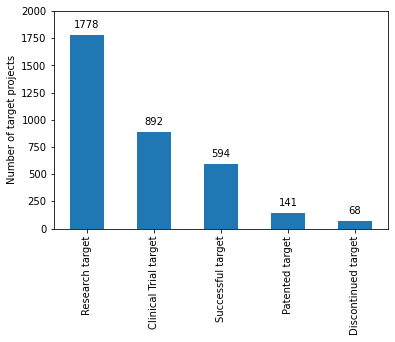

In [ ]:
label2 = label.copy()#.drop_duplicates("SYMBOL").copy()
ax = label2["TARGTYPE"].value_counts().plot.bar(ylim=(0,2000), ylabel="Number of target projects")

for p in ax.patches:
  ax.annotate(np.round(p.get_height(),decimals=0), (p.get_x()+p.get_width()/2., 
  p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

### 2.5) Export dataset

In [ ]:
label[["TARGTYPE"]].to_csv("Intermediate_Assets/ground_truth.csv")